# Import and global variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import datetime
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [3]:
xl_writer = pd.ExcelWriter(f"covid19_world_data_{now}.xlsx")

# Data

data from https://github.com/CSSEGISandData/COVID-19

or

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

# Cases

In [4]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [5]:
df = pd.read_csv(url)

In [6]:
df.to_excel(xl_writer, "raw")

In [7]:
df.drop(columns=['Lat', 'Long'], inplace=True)

In [8]:
df.head()

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,906,933,996,1026,1092,1176,1279,1351,1463,1531
1,NaN,Albania,0,0,0,0,0,0,0,0,...,539,548,562,584,609,634,663,678,712,726
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,696,704,713,717,717,723,723,731,738,738
4,NaN,Angola,0,0,0,0,0,0,0,0,...,19,24,24,24,24,25,25,25,25,26


In [9]:
countries = df["Country/Region"].unique()

In [10]:
countries.sort()

In [11]:
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [12]:
province = df["Province/State"]

In [13]:
province.dropna(inplace=True)

In [14]:
province = province.unique()

In [15]:
province.sort()

In [16]:
province

array(['Alberta', 'Anguilla', 'Anhui', 'Aruba',
       'Australian Capital Territory', 'Beijing', 'Bermuda',
       'Bonaire, Sint Eustatius and Saba', 'British Columbia',
       'British Virgin Islands', 'Cayman Islands', 'Channel Islands',
       'Chongqing', 'Curacao', 'Diamond Princess',
       'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana',
       'French Polynesia', 'Fujian', 'Gansu', 'Gibraltar',
       'Grand Princess', 'Greenland', 'Guadeloupe', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Isle of Man',
       'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Manitoba',
       'Martinique', 'Mayotte', 'Montserrat', 'New Brunswick',
       'New Caledonia', 'New South Wales', 'Newfoundland and Labrador',
       'Ningxia', 'Northern Territory', 'Northwest Territories',
       'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Qinghai',
       'Quebec', 'Queensland

In [17]:
def extract_data(data_frame, country, region=None, groupby=False):
    if groupby:
        s = data_frame[data_frame["Country/Region"] == country].groupby(by=["Country/Region",]).sum().stack().droplevel(level=0)
    else:
        d = data_frame[(data_frame["Country/Region"] == country)]
        if region:
            s = d[d["Province/State"] == region].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)

        else:
            s = d[d["Province/State"].isna()].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
    s.index = pd.to_datetime(s.index)
    df = s.to_frame()
    if region:
        df.columns = [region,]
    else:
        df.columns = [country,]
    df["day_of_year"] = df.index.dayofyear
    df.reset_index(inplace=True)
    df.columns = ['date'] + list(df.columns[1:])
    return df.set_index(['date', 'day_of_year'])

In [18]:
def plot_data(dataframe, logx=False, logy=False, **kwargs):
    if logx:
        df = dataframe.reset_index(level=0, drop=True)
        df.plot(logx=logx, logy=logy, **kwargs)
    else:
        df = dataframe.reset_index(level=1, drop=True)
        df.plot(logy=logy, **kwargs)
    plt.show()
            

# Switzerland

In [19]:
swiss = extract_data(df, "Switzerland")

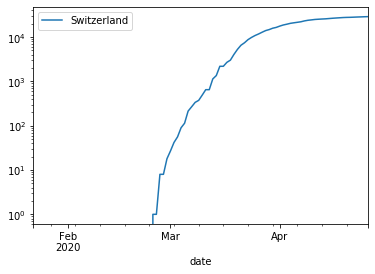

In [20]:
plot_data(swiss, logy=True)

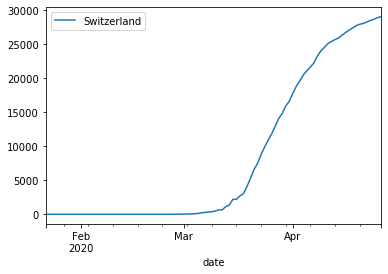

In [21]:
plot_data(swiss)

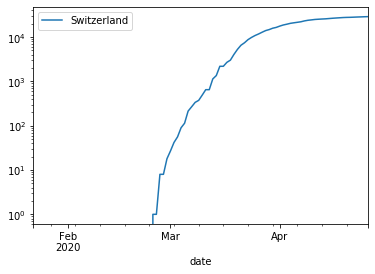

In [147]:
plot_data(swiss, logy=True)

# Europe

In [23]:
italy = extract_data(df, "Italy")

In [24]:
france = extract_data(df, "France")

In [25]:
uk = extract_data(df, "United Kingdom")

In [26]:
spain = extract_data(df, "Spain")

In [27]:
germany =  extract_data(df, "Germany")

In [28]:
austria =  extract_data(df, "Austria")

In [29]:
europe = pd.concat([swiss, italy, france, germany, austria, spain, uk], axis=1)

In [30]:
# europe.columns = ['Switzerland', 'Italy', 'France', 'Germany', 'Austria', 'Spain', 'UK']

In [31]:
europe

,,Switzerland,Italy,France,Germany,Austria,Spain,United Kingdom
date,day_of_year,,,,,,,
2020-01-22,22,0,0,0,0,0,0,0
2020-01-23,23,0,0,0,0,0,0,0
2020-01-24,24,0,0,2,0,0,0,0
2020-01-25,25,0,0,3,0,0,0,0
2020-01-26,26,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...
2020-04-22,113,28268,187327,154715,150648,14925,208389,133495
2020-04-23,114,28496,189973,157026,153129,15002,213024,138078
2020-04-24,115,28677,192994,158636,154999,15071,219764,143464


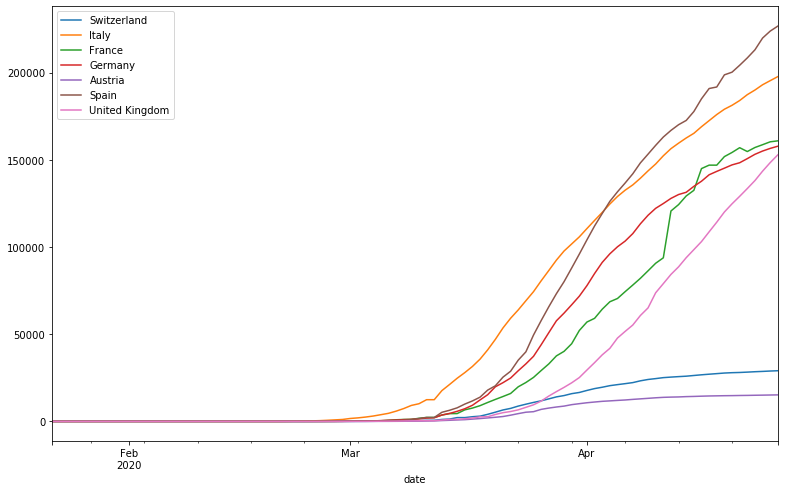

In [32]:
plot_data(europe, figsize=(13, 8))

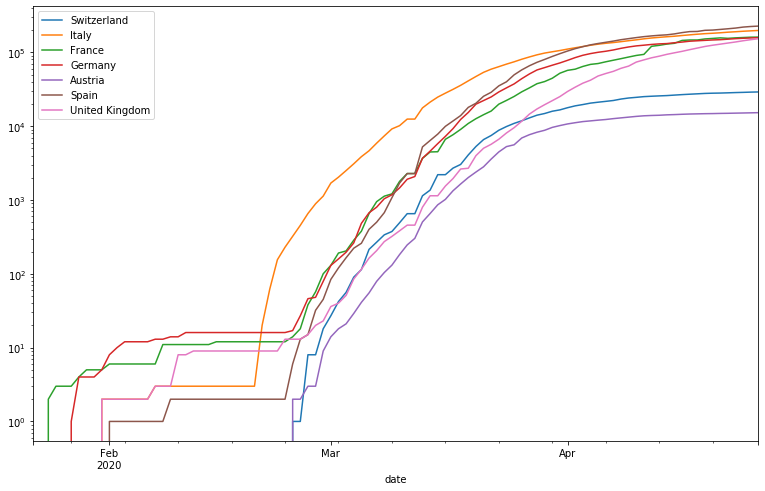

In [33]:
plot_data(europe, logy=True, figsize=(13, 8))

# USA

In [35]:
us = extract_data(df, country="US", groupby=True)

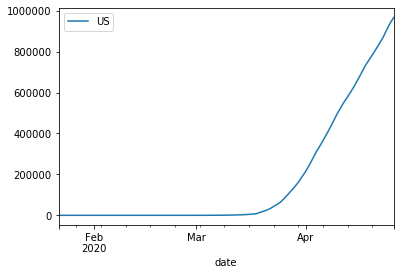

In [36]:
plot_data(us)

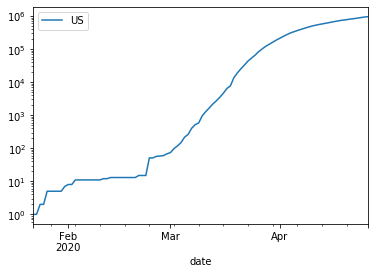

In [148]:
plot_data(us, logy=True)

# Europe + USA

In [38]:
comp_us = pd.concat([europe, us], axis=1)

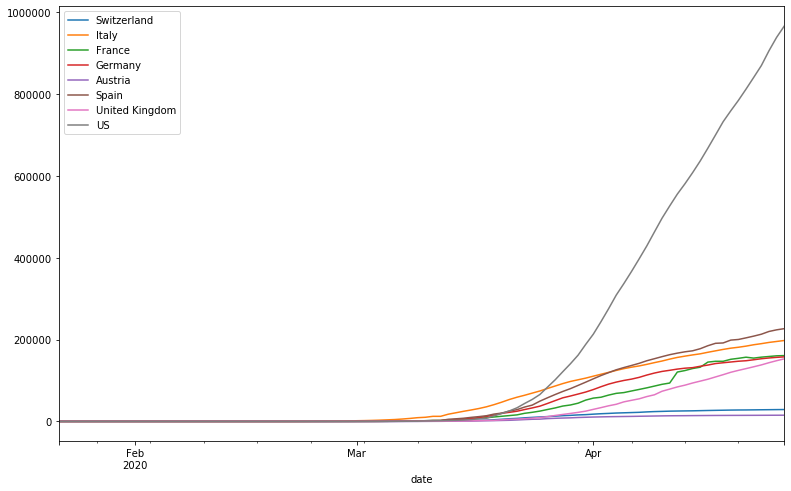

In [149]:
plot_data(comp_us, figsize=(13, 8))

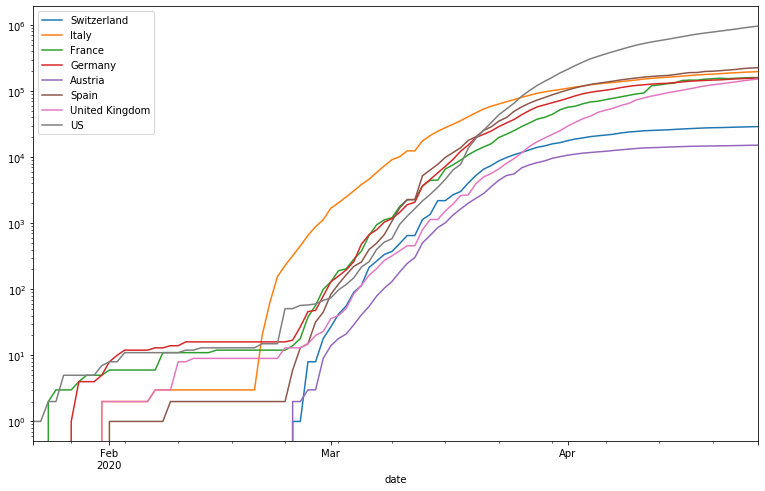

In [40]:
plot_data(comp_us, logy=True, figsize=(13, 8))

# Worldwide

In [41]:
world = df.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [42]:
world.index = pd.to_datetime(world.index)

In [43]:
world["day_of_year"] = world.index.dayofyear

In [44]:
world.reset_index(inplace=True)

In [45]:
world.columns = ["date", "world_cases", "day_of_year"]

In [46]:
world.set_index(["date", "day_of_year"], inplace=True)

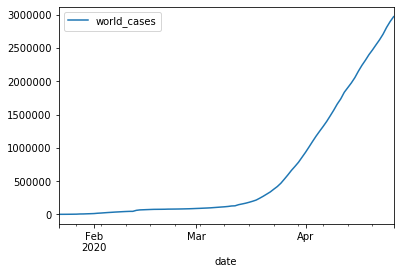

In [47]:
plot_data(world)

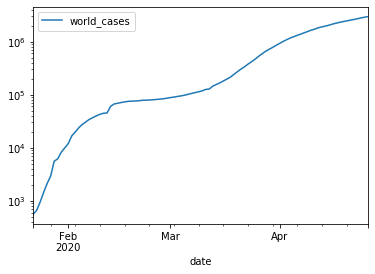

In [48]:
plot_data(world, logy=True)

# Iran

In [50]:
iran = extract_data(df, "Iran")

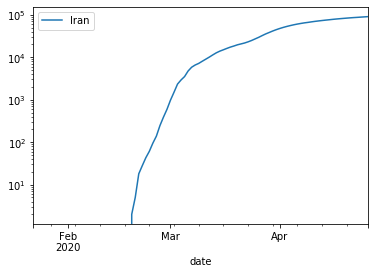

In [150]:
plot_data(iran, logy=True)

In [52]:
comp_iran = pd.concat([comp_us, iran], axis=1)

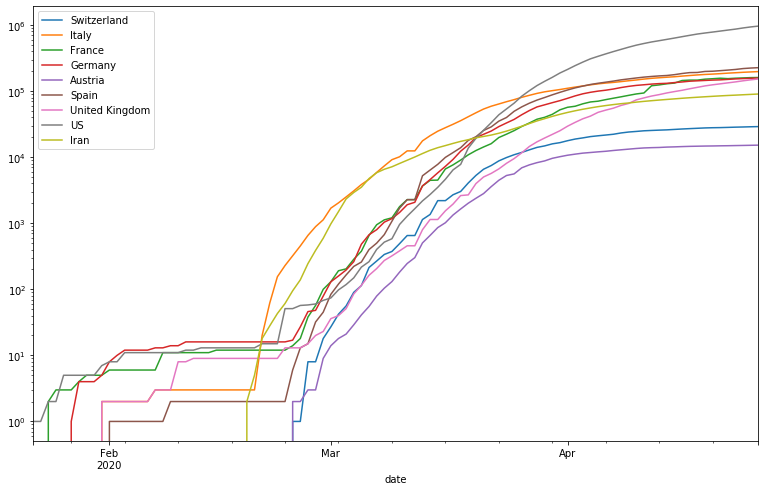

In [166]:
plot_data(comp_iran, logy=True, figsize=(13, 8))

# China

In [54]:
china = extract_data(df, "China", groupby=True)

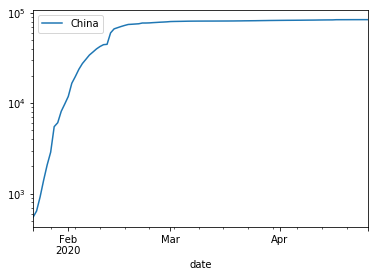

In [167]:
plot_data(china, logy=True)

In [56]:
comp_china = pd.concat([china, comp_us], axis=1)

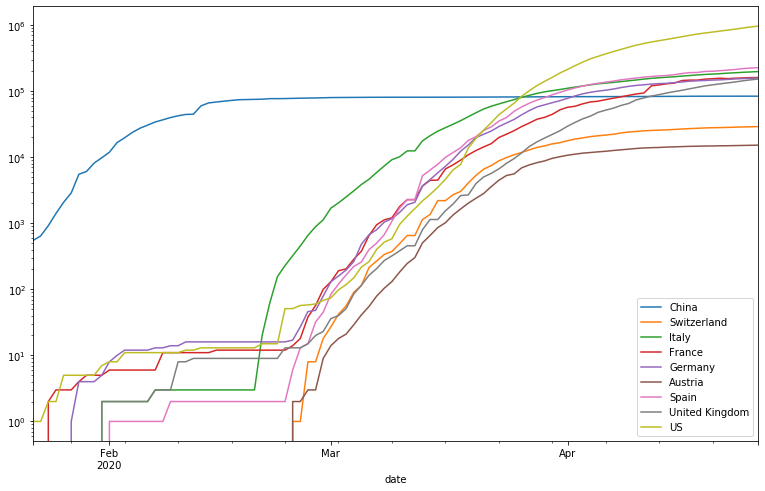

In [151]:
plot_data(comp_china, logy=True, figsize=(13, 8))

# Shanghai

In [58]:
shanghai = extract_data(df, "China", "Shanghai")

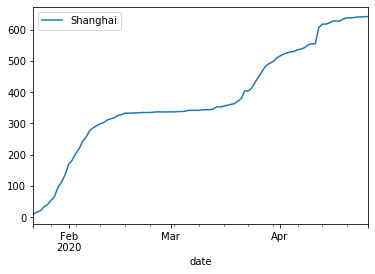

In [60]:
plot_data(shanghai)

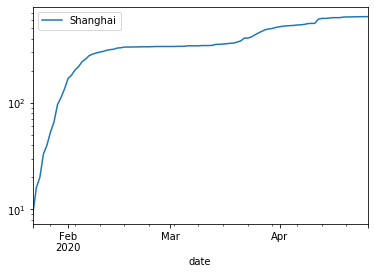

In [152]:
plot_data(shanghai, logy=True)

# Singapore

In [61]:
singapore = extract_data(df, "Singapore")

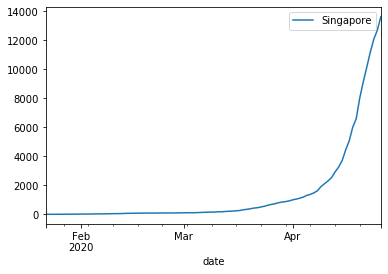

In [62]:
plot_data(singapore)

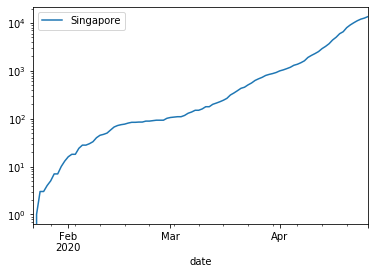

In [153]:
plot_data(singapore, logy=True)

# South Korea

In [64]:
kr = extract_data(df, "Korea, South")

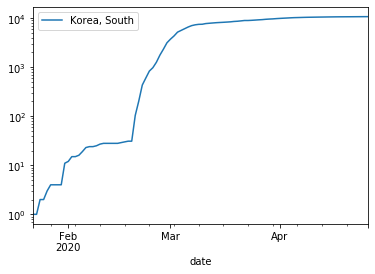

In [154]:
plot_data(kr, logy=True)

# South Central China

## Hong Kong

In [66]:
hong_kong = extract_data(df,"China", "Hong Kong")

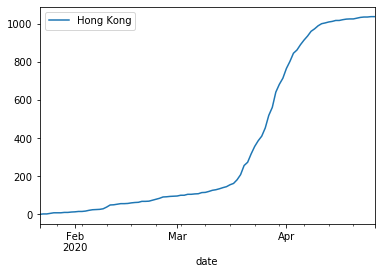

In [155]:
plot_data(hong_kong)

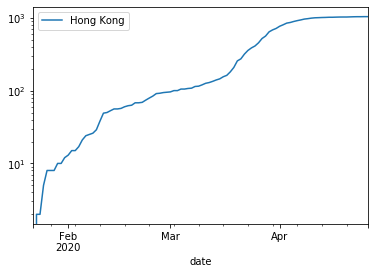

In [156]:
plot_data(hong_kong, logy=True)

## Hubei (Wuhan)

In [69]:
hubei = extract_data(df,"China", "Hubei")

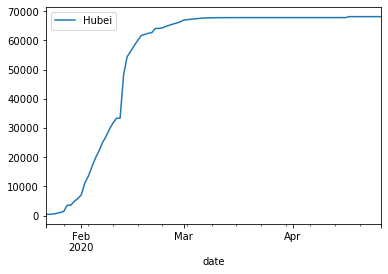

In [70]:
plot_data(hubei)

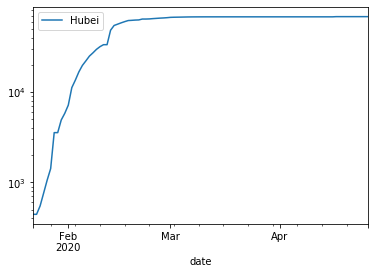

In [146]:
plot_data(hubei, logy=True)

## Henan

In [72]:
henan = extract_data(df, "China", "Henan")

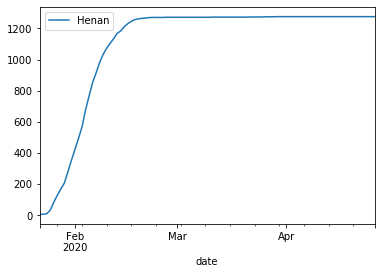

In [73]:
plot_data(henan)

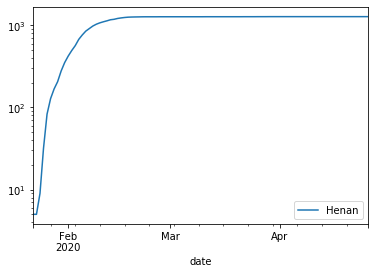

In [157]:
plot_data(henan, logy=True)

## Hunan

In [75]:
hunan = extract_data(df, "China", "Hunan")

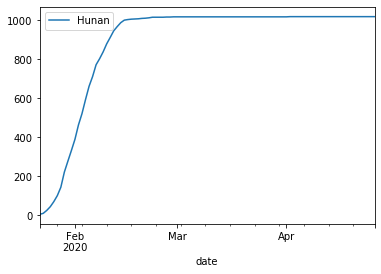

In [76]:
plot_data(hunan)

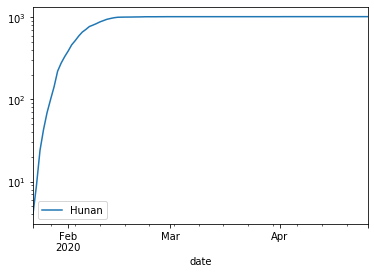

In [158]:
plot_data(hunan, logy=True)

## Guangdong

In [78]:
guangdong = extract_data(df, "China", "Guangdong")

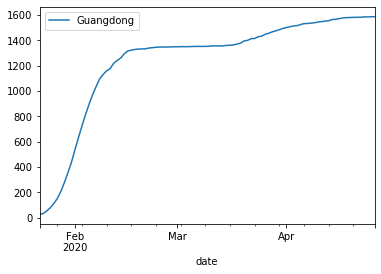

In [79]:
plot_data(guangdong)

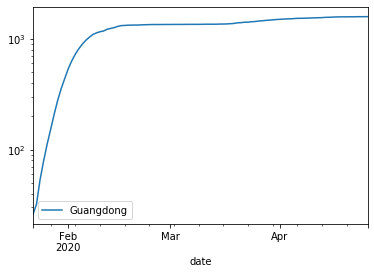

In [159]:
plot_data(guangdong, logy=True)

## Guangxi

In [81]:
guangxi = extract_data(df, "China", "Guangxi")

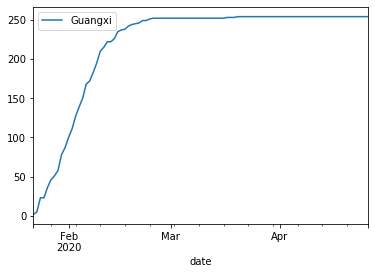

In [82]:
plot_data(guangxi)

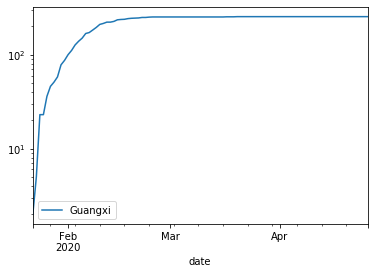

In [160]:
plot_data(guangxi, logy=True)

# South-Asia

In [84]:
south_asia = pd.concat([singapore, hong_kong, shanghai, kr, italy], axis=1)

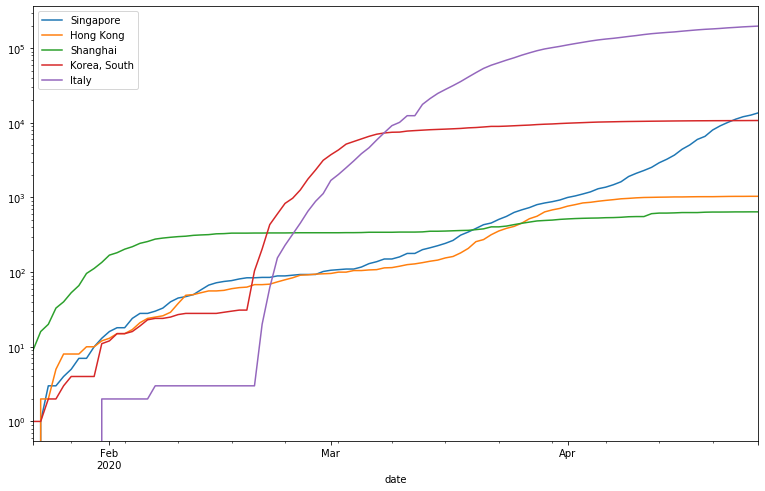

In [161]:
plot_data(south_asia, logy=True, figsize=(13, 8))

# North Europe

In [86]:
sweden = extract_data(df, "Sweden")

In [87]:
norway = extract_data(df, "Norway")

In [88]:
danemark = extract_data(df, 'Danemark')

In [89]:
finland = extract_data(df, 'Finland')

In [90]:
nl = extract_data(df, "Netherlands")

In [91]:
nort_eu = pd.concat([swiss, germany, sweden, norway, danemark, finland, nl], axis=1)

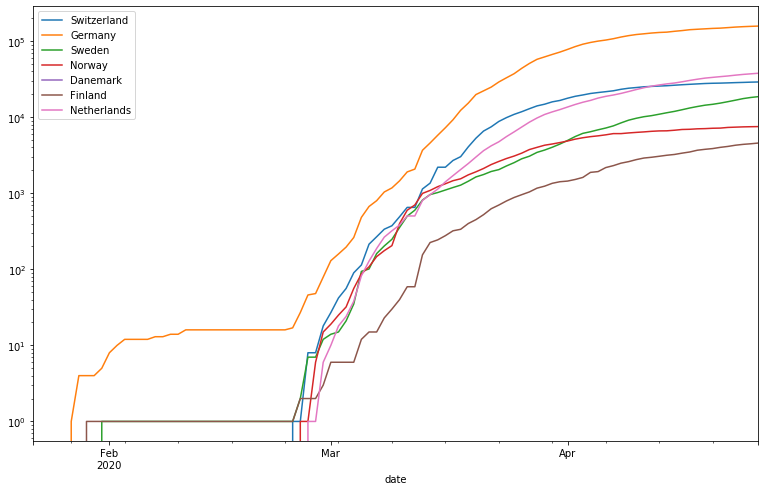

In [162]:
plot_data(nort_eu, logy=True, figsize=(13, 8))

# Death

In [93]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [94]:
death = pd.read_csv(url)

In [95]:
death.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,30,30,33,36,36,40,42,43,47,50
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,26,26,26,26,26,27,27,27,27,28
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,364,367,375,384,392,402,407,415,419,425
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,35,35,36,37,37,37,37,40,40,40
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [96]:
death.drop(columns=['Lat', 'Long'], inplace=True)

In [97]:
uk_death = extract_data(death, "United Kingdom")

In [98]:
us_death = extract_data(death, "US", groupby=True)

In [99]:
it_death = extract_data(death, "Italy")

In [100]:
es_death = extract_data(death, "Spain")

In [101]:
de_death = extract_data(death, "Germany")

In [102]:
cn_death = extract_data(death, "China", groupby=True)

In [103]:
fr_death = extract_data(death, "France")

In [104]:
ch_death = extract_data(death, "Switzerland")

In [105]:
comp_death = pd.concat([it_death, uk_death, us_death, es_death, de_death, cn_death, ch_death, fr_death], axis=1)

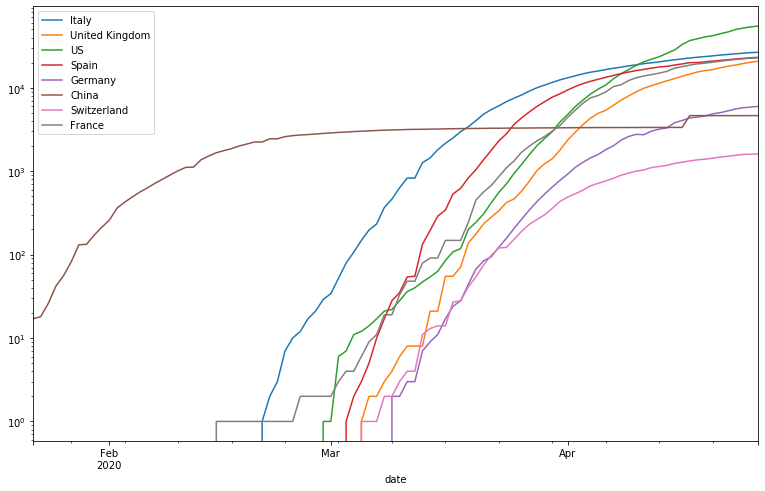

In [163]:
plot_data(comp_death, logy=True, figsize=(13, 8))

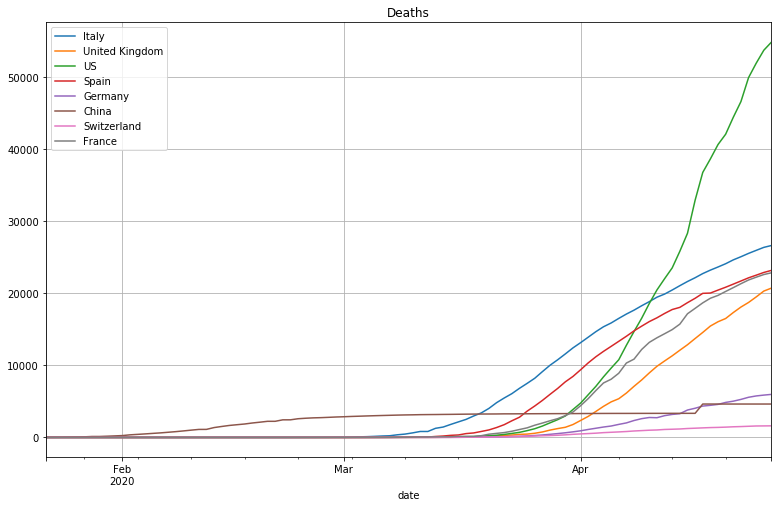

In [107]:
plot_data(comp_death, figsize=(13, 8), title="Deaths", grid=True)

In [108]:
world_death = death.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [109]:
world_death.index = pd.to_datetime(world_death.index)

In [110]:
world_death["day_of_year"] = world_death.index.dayofyear

In [111]:
world_death.reset_index(inplace=True)

In [112]:
world_death.columns = ["date", "world_death", "day_of_year"]

In [113]:
world_death.set_index(["date", "day_of_year"], inplace=True)

In [115]:
comp_world = pd.concat([world, world_death], axis=1)

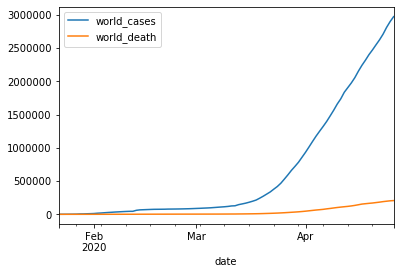

In [116]:
plot_data(comp_world)

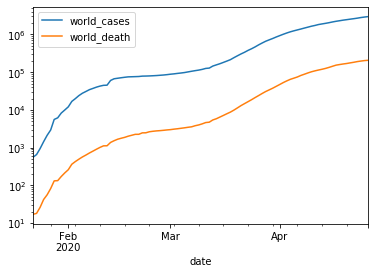

In [165]:
plot_data(comp_world, logy=True)

In [120]:
comp_world.to_excel(xl_writer, "World")

In [121]:
xl_writer.close()

In [122]:
df.columns[-1]

'4/26/20'

In [123]:
df['4/17/20']

0       906
1       539
2      2418
3       696
4        19
       ... 
259       1
260       4
261       6
262       4
263       1
Name: 4/17/20, Length: 264, dtype: int64

In [124]:
df_summary_cases = pd.DataFrame(df[["Country/Region", df.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [125]:
df_summary_cases.columns = ["Country", "Cases"]

In [126]:
df_summary_deaths = pd.DataFrame(death[["Country/Region", death.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [127]:
df_summary_deaths.columns = ["Country", "Deaths"]

In [128]:
df_summary = pd.merge(df_summary_cases, df_summary_deaths, how="outer", on="Country")

In [129]:
iso_code = pd.read_csv("country_name_to_iso_code.csv")
iso_code.loc[iso_code["Country"] == "Namibia", "alpha-2"] = "NA"
iso_code[iso_code["Country"] == "Namibia"]

,Unnamed: 0,Country,alpha-2
150,152,Namibia,NA


In [130]:
df_summary = pd.merge(df_summary, iso_code, how="outer", on="Country")
df_summary.drop(columns=["Unnamed: 0", ], inplace=True)

In [131]:
df_summary

,Country,Cases,Deaths,alpha-2
0,Afghanistan,1531.0,50.0,AF
1,Albania,726.0,28.0,AL
2,Algeria,3382.0,425.0,DZ
3,Andorra,738.0,40.0,AD
4,Angola,26.0,2.0,AO
...,...,...,...,...
245,Tuvalu,NaN,NaN,TV
246,U.S. Virgin Islands,NaN,NaN,VI
247,United States,NaN,NaN,US
248,Vanuatu,NaN,NaN,VU


In [132]:
df_summary.sort_values(by=["Cases",], ascending=False)

,Country,Cases,Deaths,alpha-2
171,US,965785.0,54881.0,US
156,Spain,226629.0,23190.0,ES
84,Italy,197675.0,26644.0,IT
61,France,162220.0,22890.0,FR
65,Germany,157770.0,5976.0,DE
...,...,...,...,...
245,Tuvalu,NaN,NaN,TV
246,U.S. Virgin Islands,NaN,NaN,VI
247,United States,NaN,NaN,US
248,Vanuatu,NaN,NaN,VU


In [133]:
number_of_countries = 15

In [134]:
by_countries = df_summary.copy().drop(columns="alpha-2").set_index("Country")

In [135]:
by_countries.sort_values(by="Cases", ascending=False, inplace=True)

In [136]:
by_countries.head(20)

,Cases,Deaths
Country,,
US,965785.0,54881.0
Spain,226629.0,23190.0
Italy,197675.0,26644.0
France,162220.0,22890.0
Germany,157770.0,5976.0
United Kingdom,154037.0,20794.0
Turkey,110130.0,2805.0
Iran,90481.0,5710.0
China,83912.0,4637.0


In [137]:
[by_countries.iloc[:number_of_countries].sum(), ]

[Cases     2453068.0
 Deaths     188416.0
 dtype: float64]

In [138]:
by_countries = pd.concat([
    by_countries.iloc[:number_of_countries],
    pd.DataFrame([by_countries.iloc[number_of_countries:].sum(), ])
]
)

In [139]:
by_countries

,Cases,Deaths
US,965785.0,54881.0
Spain,226629.0,23190.0
Italy,197675.0,26644.0
France,162220.0,22890.0
Germany,157770.0,5976.0
United Kingdom,154037.0,20794.0
Turkey,110130.0,2805.0
Iran,90481.0,5710.0
China,83912.0,4637.0
Russia,80949.0,747.0


In [140]:
by_countries.rename(index={0: 'others'}, inplace=True)

In [141]:
by_countries

,Cases,Deaths
US,965785.0,54881.0
Spain,226629.0,23190.0
Italy,197675.0,26644.0
France,162220.0,22890.0
Germany,157770.0,5976.0
United Kingdom,154037.0,20794.0
Turkey,110130.0,2805.0
Iran,90481.0,5710.0
China,83912.0,4637.0
Russia,80949.0,747.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A8FB8FC408>,
      dtype=object)

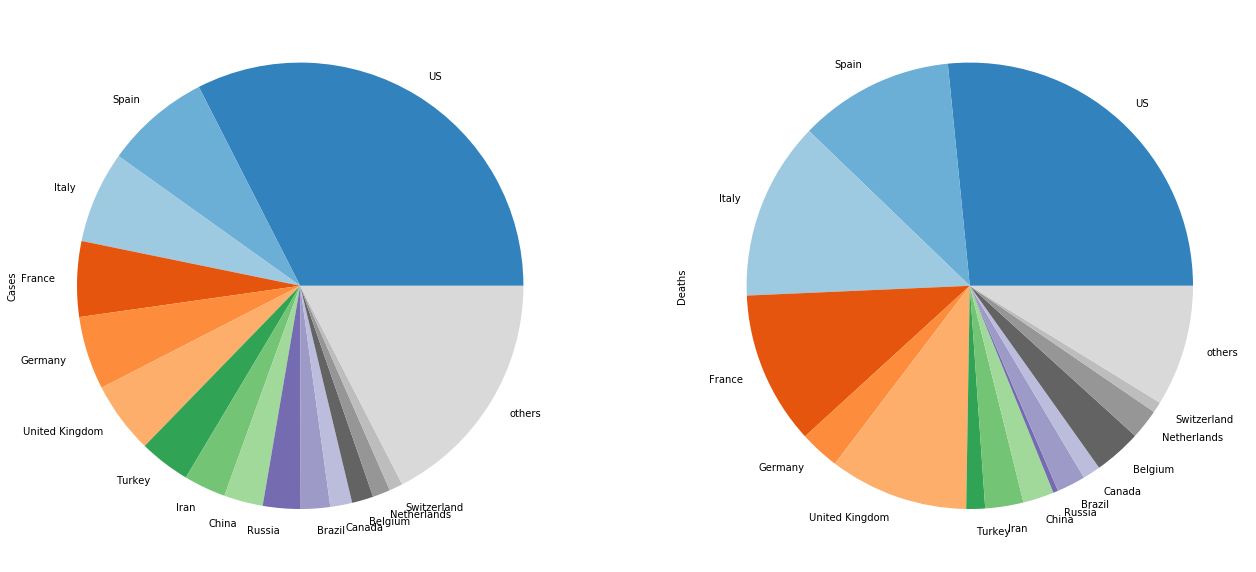

In [142]:
by_countries.plot.pie(subplots=True, figsize=(22, 11), cmap=plt.cm.get_cmap('tab20c'), legend=False)

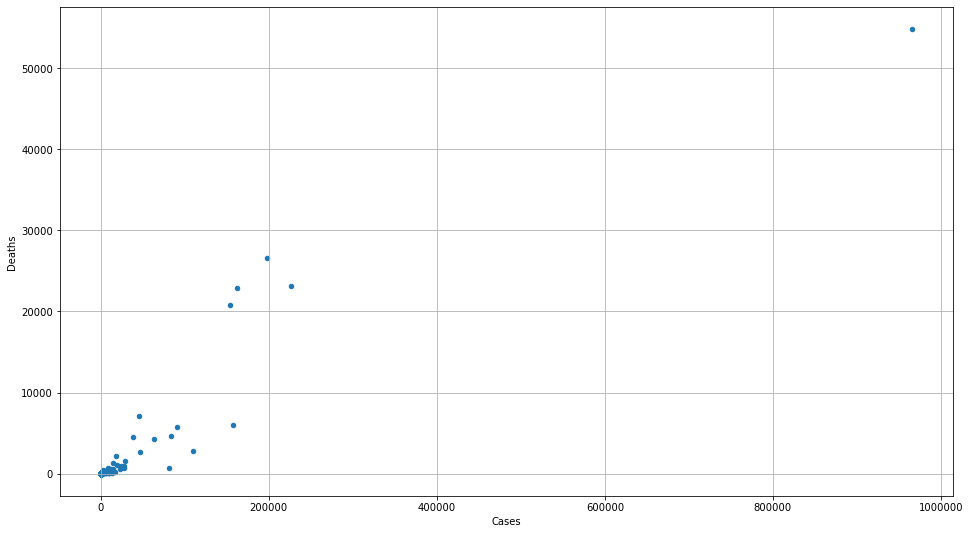

In [143]:
df_summary.plot.scatter(x="Cases", y="Deaths", figsize=(16, 9), grid=True)

In [168]:
comp_world

,,world_cases,world_death
date,day_of_year,,
2020-01-22,22,555,17
2020-01-23,23,654,18
2020-01-24,24,941,26
2020-01-25,25,1434,42
2020-01-26,26,2118,56
...,...,...,...
2020-04-22,113,2623049,183064
2020-04-23,114,2707728,190857
2020-04-24,115,2809499,197004


In [169]:
comp_world["daily cases"] = comp_world["world_cases"].diff()

In [170]:
comp_world["daily deaths"] = comp_world["world_death"].diff()

In [171]:
comp_world

,,world_cases,world_death,daily cases,daily deaths
date,day_of_year,,,,
2020-01-22,22,555,17,NaN,NaN
2020-01-23,23,654,18,99,1
2020-01-24,24,941,26,287,8
2020-01-25,25,1434,42,493,16
2020-01-26,26,2118,56,684,14
...,...,...,...,...,...
2020-04-22,113,2623049,183064,74958,6482
2020-04-23,114,2707728,190857,84679,7793
2020-04-24,115,2809499,197004,101771,6147


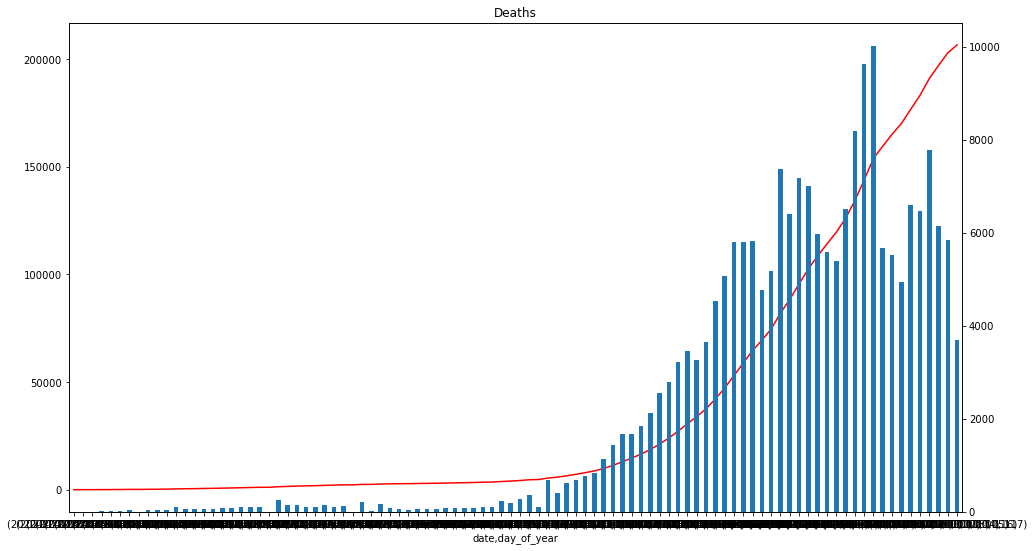

In [175]:
comp_world["world_death"].plot(figsize=(16,9), color="r", title="Deaths")
comp_world["daily deaths"].plot.bar(secondary_y=True, rot=0, figsize=(16,9))

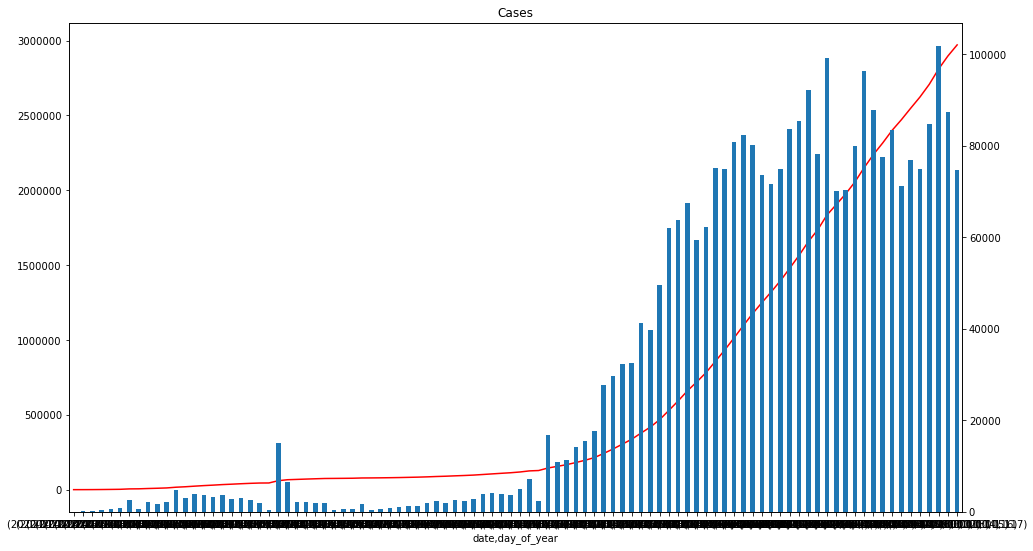

In [178]:
comp_world["world_cases"].plot(figsize=(16,9), color="r", title="Cases")
comp_world["daily cases"].plot.bar(secondary_y=True, rot=0, figsize=(16,9))